In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import wrf
import netCDF4 as nc
import warnings
import pyart
import tqdm
import metpy.calc as mpcalc

warnings.simplefilter("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


0.3.0


In [21]:
def calc_grad_theta(theta):
    
    theta_np = theta.values
    dx, dy = mpcalc.lat_lon_grid_deltas(theta.XLONG.values, theta.XLAT.values)
    dtheta_dy, dtheta_dx = mpcalc.gradient(theta_np, deltas=[dy.to("km"), dx.to("km")])
    grad_theta = dtheta_dy + dtheta_dx
    grad_theta = xr.DataArray(grad_theta.data,dims=["south_north","west_east"])
    grad_theta["XLONG"] = theta.XLONG
    
    return grad_theta

def load_transect(tpath,t_fname,hpath,h_fname,mean_motion_top):

    ctrl = xr.open_dataset(tpath + t_fname)
    dbz = xr.open_dataset(hpath + "dbz_" + h_fname)
    ctrl_highres = xr.open_dataset(hpath + h_fname, decode_times=False)
    ctrl_highres_wrf = nc.Dataset(hpath + h_fname)
    ctrl["system_relative_along_transect_wind"] = ctrl["along_transect_wind"] - ctrl["along_transect_wind"].sel(vertical=slice(0,mean_motion_top)).\
                        mean(("vertical","cross_line_idx"))
    
    return ctrl.assign_coords({"transect":ctrl.transect}), ctrl_highres, ctrl_highres_wrf, dbz

def plot_transect_map(ax, ctrl, ctrl_highres, ctrl_highres_wrf, grad_theta_thresh=2):
    
    
    #plt.figure()
    ctrl_tstart = [ctrl.transect_starts_lon,ctrl.transect_starts_lat]
    ctrl_tend = [ctrl.transect_ends_lon,ctrl.transect_ends_lat]
    
    
    for i in ctrl.transect.values:
        plt.plot([ctrl_tstart[0][i],ctrl_tend[0][i]], [ctrl_tstart[1][i],ctrl_tend[1][i]], color="grey", ls="-", lw=0.5)
        if (i % 4) == 0:
            plt.text(ctrl_tend[0][i], ctrl_tend[1][i], str(i), color="k", fontdict={"weight":"bold"})
    extents = ax.get_extent()

    c=np.sqrt(ctrl_highres["U10"]**2 + ctrl_highres["V10"]**2).squeeze().plot(ax=ax,x="XLONG",y="XLAT",cmap="Reds", levels=np.linspace(0,20,11), add_colorbar=False)
    ctrl_highres.isel(Time=0,west_east=slice(0,-1,30),south_north=slice(0,-1,30)).plot.quiver("XLONG","XLAT","U10","V10",scale=300,width=0.003,ax=ax)
    cb=plt.colorbar(c)
    cb.set_label("10 m wind speed (m/s)")
    
    
    theta = wrf.getvar(ctrl_highres_wrf, "theta").isel(bottom_top=0)
    xr.plot.contour(calc_grad_theta(theta),levels=[grad_theta_thresh],colors=["tab:blue"],x="XLONG",y="XLAT",ax=ax)

    # ylim = ctrl.line_ylim
    # xlim = ctrl.line_xlim
    xlim = [np.concatenate([ctrl.transect_starts_lon,ctrl.transect_ends_lon]).min()-0.1,
            np.concatenate([ctrl.transect_starts_lon,ctrl.transect_ends_lon]).max()+0.1]
    ylim = [np.concatenate([ctrl.transect_starts_lat,ctrl.transect_ends_lat]).min()-0.1,
            np.concatenate([ctrl.transect_starts_lat,ctrl.transect_ends_lat]).max() + 0.1]    
#    ax.set_ylim(ylim)
#    ax.set_xlim(xlim)
    ax.gridlines(draw_labels=["bottom","left"], ls=":")
    
    ax.set_title(ctrl.Time.values)
    
    
def plot_transect_radar(ax, ctrl, ctrl_highres, ctrl_highres_wrf, ctrl_dbz):
    
    
   # plt.figure()
    ctrl_tstart = [ctrl.transect_starts_lon,ctrl.transect_starts_lat]
    ctrl_tend = [ctrl.transect_ends_lon,ctrl.transect_ends_lat]
    
    
    for i in ctrl.transect.values:
        plt.plot([ctrl_tstart[0][i],ctrl_tend[0][i]], [ctrl_tstart[1][i],ctrl_tend[1][i]], color="grey", ls="--")
        if (i % 4) == 0:
            plt.text(ctrl_tend[0][i], ctrl_tend[1][i], str(i), color="k", fontdict={"weight":"bold"})
    extents = ax.get_extent()

    #wrf.getvar(ctrl_highres_wrf,"mdbz").plot(x="XLONG",y="XLAT",cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.linspace(0,70,11))
    ctrl_dbz.max("bottom_top").dbz.plot(x="XLONG",y="XLAT",cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.linspace(0,70,11))
    ctrl_highres.isel(Time=0,west_east=slice(0,-1,30),south_north=slice(0,-1,30)).plot.quiver("XLONG","XLAT","U10","V10",scale=300,width=0.003)    

    xlim = [np.concatenate([ctrl.transect_starts_lon,ctrl.transect_ends_lon]).min()-0.1,
            np.concatenate([ctrl.transect_starts_lon,ctrl.transect_ends_lon]).max()+0.1]
    ylim = [np.concatenate([ctrl.transect_starts_lat,ctrl.transect_ends_lat]).min()-0.1,
            np.concatenate([ctrl.transect_starts_lat,ctrl.transect_ends_lat]).max() + 0.1]    
    #ax.set_ylim(ylim)
    #ax.set_xlim(xlim)
    ax.gridlines(draw_labels=["bottom","left"], ls=":")
    
    ax.set_title(ctrl.Time.values)
    
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)    
    
def plot_transect(ctrl):
    
    plt.figure(figsize=[18,4])
    plt.subplot(1,3,1)
    xr.plot.contourf(ctrl.sel(vertical=slice(0,6000)).theta_pert.mean("transect"),levels=np.arange(-4,0.5,0.5),cmap="Blues_r",alpha=0.7)
#    xr.plot.contour(ctrl.sel(vertical=slice(0,6000)).theta_pert.mean("transect"),levels=[-2],colors=["k"],linestyles="-")
    xr.plot.contour(ctrl.sel(vertical=slice(0,2000)).theta_pert.mean("transect"),levels=np.arange(-4,0.5,0.5),colors=["k"],linestyles="-",linewidths=0.5)    
    ctrl.sel(vertical=slice(0,6000,2),cross_line_idx=slice(2,50,10)).mean("transect").plot.quiver("cross_line_idx","vertical","system_relative_along_transect_wind","w",width=0.005,color="k",scale=100)
    plt.ylim([0,6000])

    plt.subplot(1,3,2)
    xr.plot.contourf(ctrl.sel(vertical=slice(0,6000)).ground_rel_ws.mean("transect"),levels=np.linspace(0,30,11),cmap="Reds")
    xr.plot.contour(ctrl.sel(vertical=slice(0,6000)).ground_rel_ws.mean("transect"),levels=[15,18],colors=["k","grey"])
    ctrl.sel(vertical=slice(0,6000,2),cross_line_idx=slice(2,50,10)).mean("transect").plot.quiver("cross_line_idx","vertical","system_relative_along_transect_wind","w",width=0.005,color="k",scale=100)
    plt.ylabel("")
    plt.ylim([0,6000])

    plt.subplot(1,3,3)
    xr.plot.contourf(ctrl.sel(vertical=slice(0,6000)).p_pert.mean("transect"),levels=np.linspace(-0.5,0.5,11),cmap="RdBu_r")
    xr.plot.contour(ctrl.sel(vertical=slice(0,6000)).buoyancy.mean("transect"),levels=[-0.10,-0.05,0,0.02,0.04],colors="k",linewidths=[3])
    ctrl.sel(vertical=slice(0,6000,2),cross_line_idx=slice(2,50,10)).mean("transect").plot.quiver("cross_line_idx","vertical","system_relative_along_transect_wind","w",width=0.005,color="k",scale=100)
    plt.ylabel("")
    plt.ylim([0,6000])
        

4it [00:31,  7.77s/it]


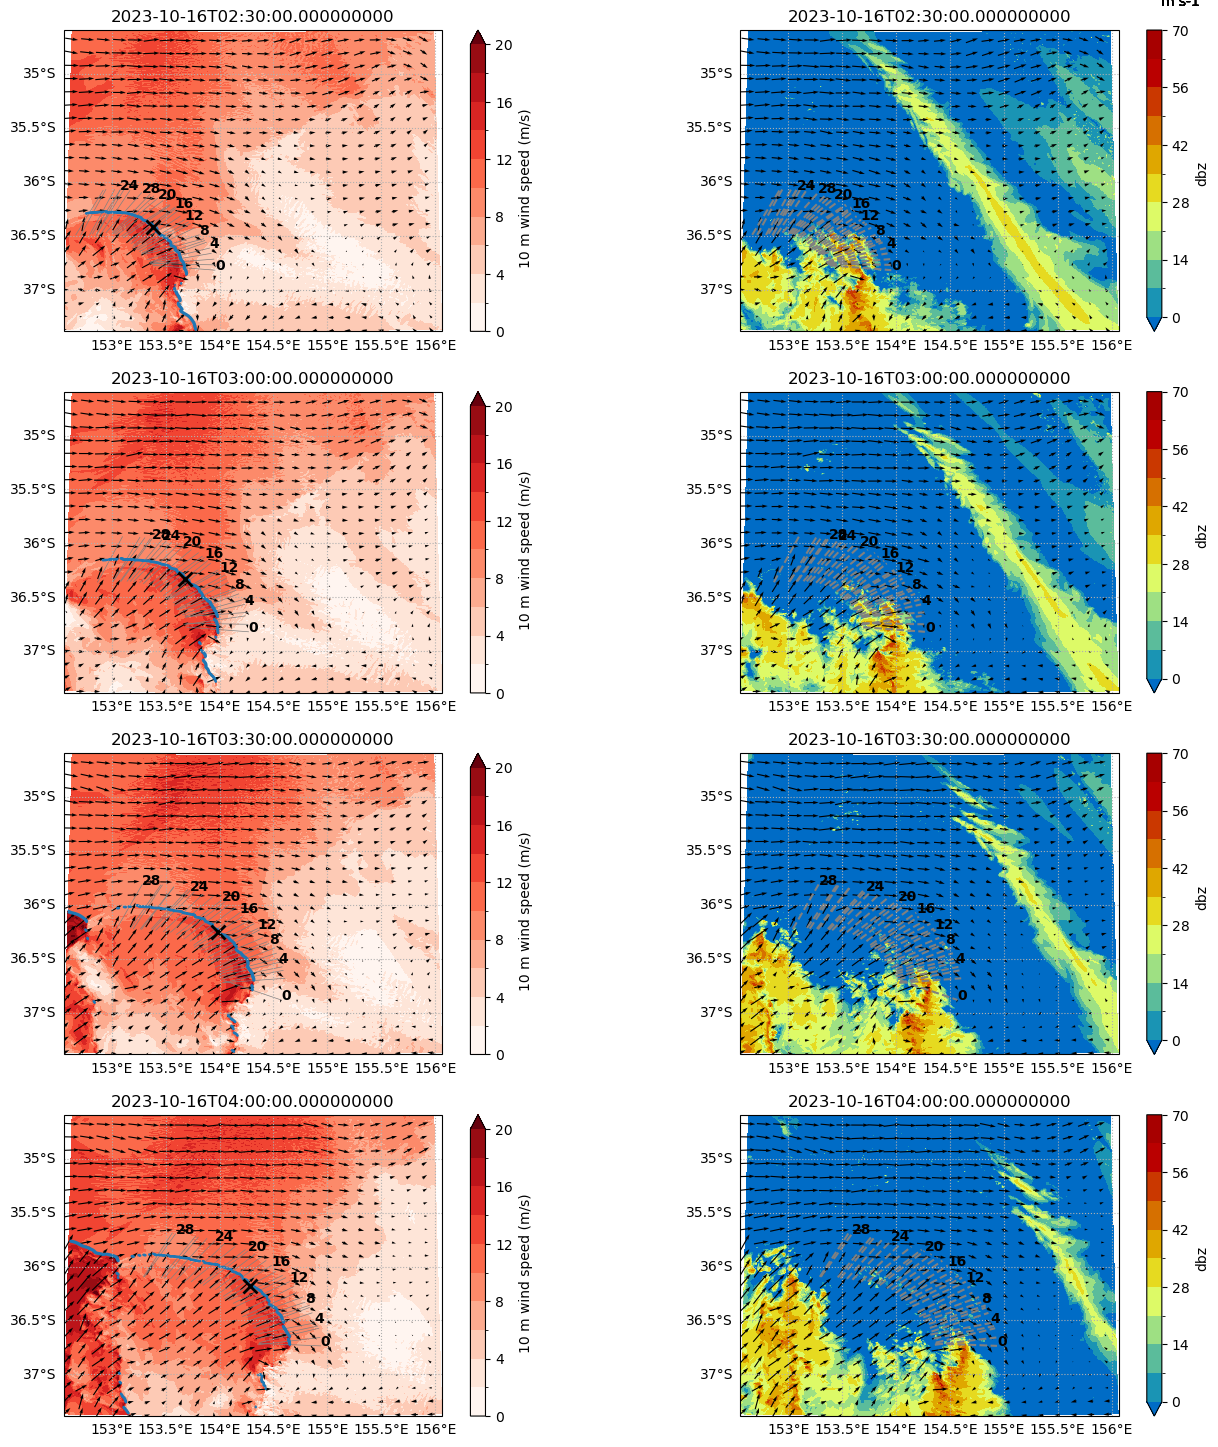

In [22]:
tpath = "/g/data/w40/ab4502/WRF_simulations/transects/"
hpath = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/"
mean_motion_top = 6000
plot_radar = True

t_fname = ["tasman_d04_20231015_20231016_ramssa_shortlead_02:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_03:00:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_03:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_04:00:00.nc"]
h_fname = ["highres_d04_2023-10-16_02:30:00",
           "highres_d04_2023-10-16_03:00:00",
           "highres_d04_2023-10-16_03:30:00",
           "highres_d04_2023-10-16_04:00:00"]
ctrl_list = []
ctrl_highres_list = []
ctrl_highres_wrf_list = []

plt.figure(figsize=[16,18])

cnt=1
for t, h in tqdm.tqdm(zip(t_fname,h_fname)):
    if plot_radar:
        ax=plt.subplot(len(t_fname),2,cnt,projection=ccrs.PlateCarree())
    else:
        ax=plt.subplot(len(t_fname),1,cnt,projection=ccrs.PlateCarree())        
    ctrl, ctrl_highres, ctrl_highres_wrf, ctrl_dbz = load_transect(tpath,t,hpath,h,mean_motion_top)
    plot_transect_map(ax,ctrl, ctrl_highres, ctrl_highres_wrf)
    system_lat = ctrl.sel(transect=15,cross_line_idx=25,method="nearest").xy_lat.values
    system_lon = ctrl.sel(transect=15,cross_line_idx=25,method="nearest").xy_lon.values
    plt.gca().plot(system_lon,system_lat,marker="x",color="k",mew=2,ms=10)    
    cnt = cnt+1
    if plot_radar:
        ax=plt.subplot(len(t_fname),2,cnt,projection=ccrs.PlateCarree())
        plot_transect_radar(ax,ctrl, ctrl_highres, ctrl_highres_wrf, ctrl_dbz)
        cnt=cnt+1
    ctrl_list.append(ctrl)
    ctrl_highres_list.append(ctrl_highres)
    ctrl_highres_wrf_list.append(ctrl_highres_wrf)    

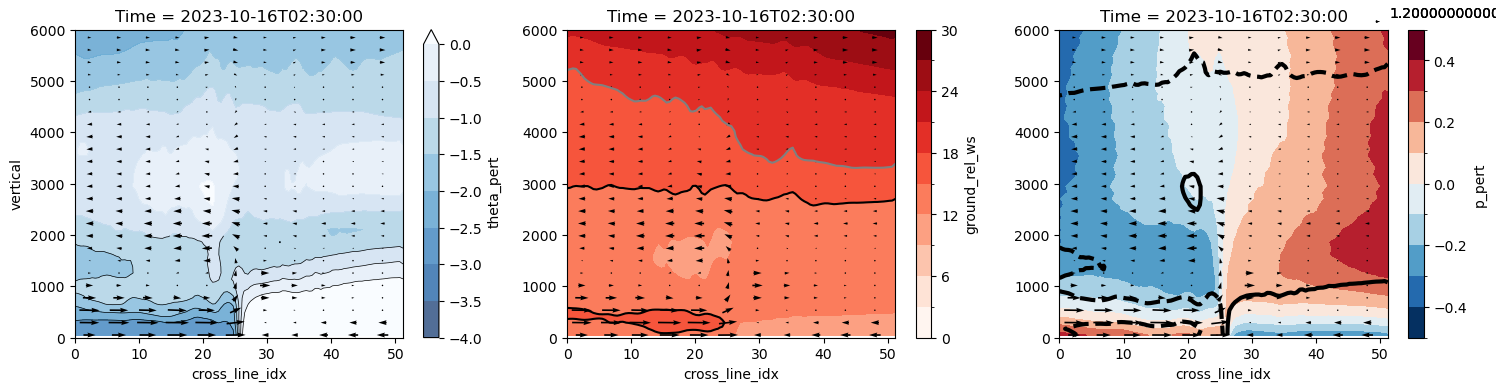

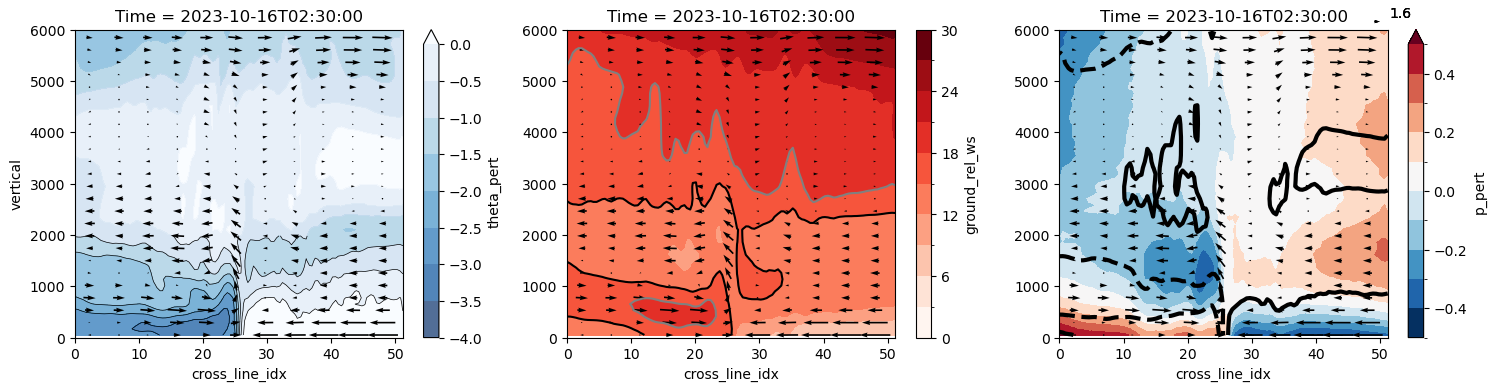

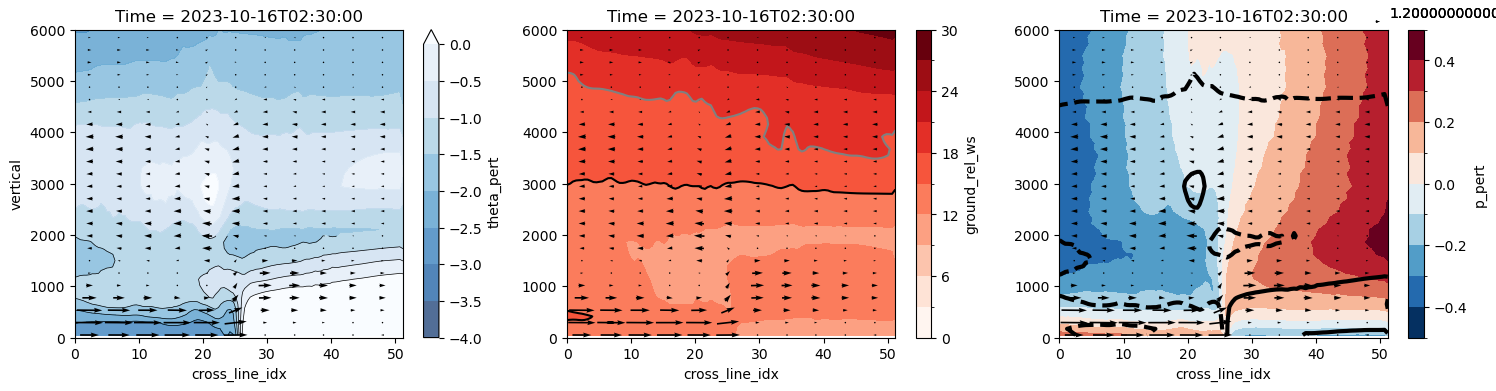

In [4]:
plot_transect(ctrl_list[0])
plot_transect(ctrl_list[0].sel(transect=slice(0,9)))
plot_transect(ctrl_list[0].sel(transect=slice(9,ctrl_list[1].transect.shape[0])))

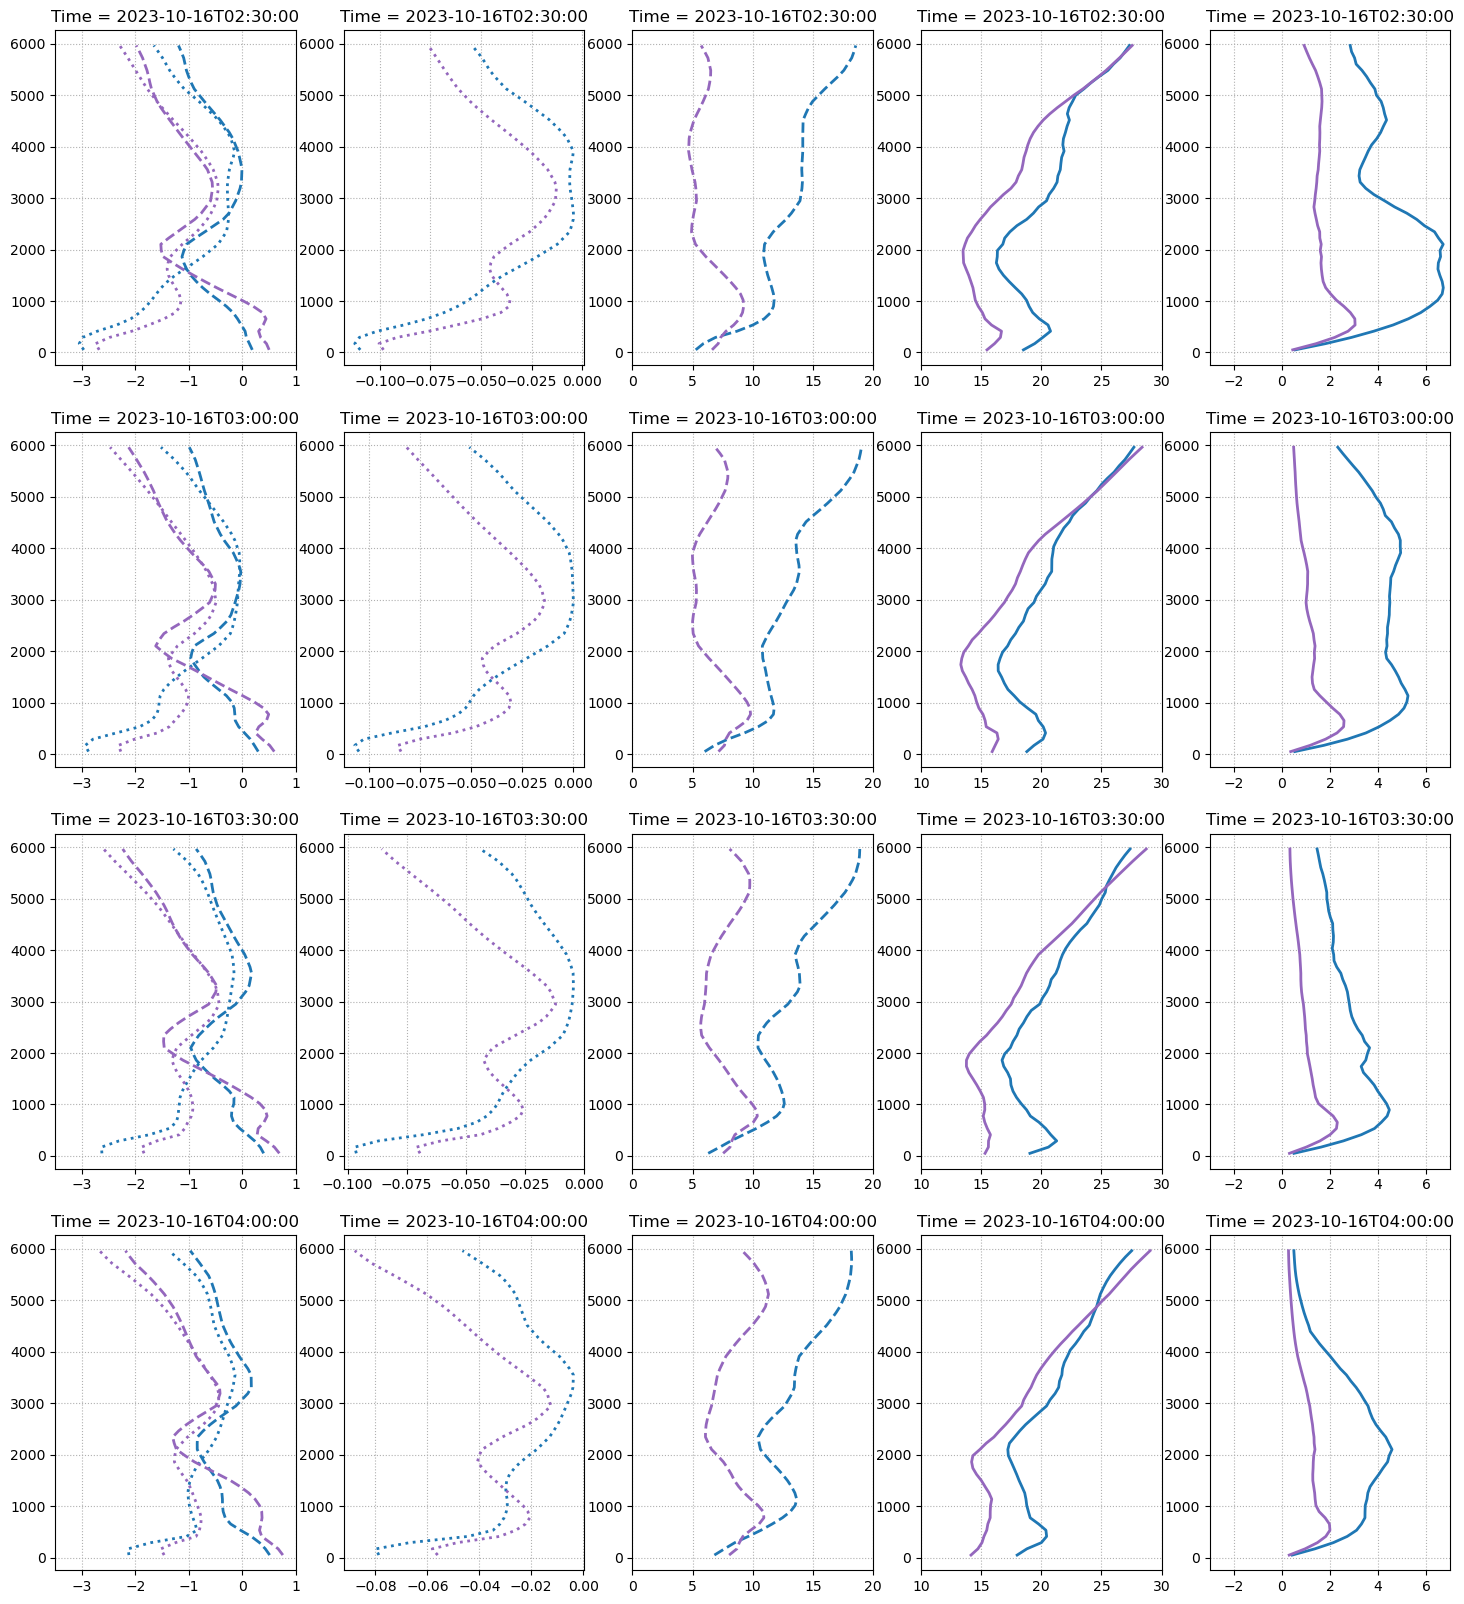

In [5]:
def plot_profile(ctrl,var,cross_slice,vert_slice,color,ls,func="mean",xlab="",ylab="",lw=2):
    if func=="mean":        
        ctrl.sel(vertical=vert_slice,cross_line_idx=cross_slice)[var].mean(("transect","cross_line_idx")).plot(y="vertical",color=color,ls=ls,lw=lw)
    elif func=="max_mean":
        ctrl.sel(vertical=vert_slice,cross_line_idx=cross_slice)[var].max("cross_line_idx").mean("transect").plot(y="vertical",color=color,ls=ls,lw=lw)        
    elif func=="min_mean":
        ctrl.sel(vertical=vert_slice,cross_line_idx=cross_slice)[var].min("cross_line_idx").mean("transect").plot(y="vertical",color=color,ls=ls,lw=lw)                
    plt.xlabel(xlab)
    plt.ylabel(ylab) 
    plt.gca().grid(ls=":")
    
plt.figure(figsize=[18,20])
rows=4
cols=5

for t in range(rows):
    plt.subplot(rows,cols,(t*cols)+1)
    plot_profile(ctrl_list[t].sel(transect=slice(0,9)),"theta_pert",slice(0,25),slice(0,6000),"tab:blue",ls=":",func="mean",xlab="",ylab="")
    plot_profile(ctrl_list[t].sel(transect=slice(9,100)),"theta_pert",slice(0,25),slice(0,6000),"tab:purple",ls=":",func="mean",xlab="",ylab="")
    plot_profile(ctrl_list[t].sel(transect=slice(0,9)),"theta_pert",slice(25,50),slice(0,6000),"tab:blue",ls="--",func="mean",xlab="",ylab="")
    plot_profile(ctrl_list[t].sel(transect=slice(9,100)),"theta_pert",slice(25,50),slice(0,6000),"tab:purple",ls="--",func="mean",xlab="",ylab="")
    plt.xlim([-3.5,1])
    
for t in range(rows):
    plt.subplot(rows,cols,(t*cols)+2)
    plot_profile(ctrl_list[t].sel(transect=slice(0,9)),"buoyancy",slice(0,25),slice(0,6000),"tab:blue",ls=":",func="mean",xlab="",ylab="")
    plot_profile(ctrl_list[t].sel(transect=slice(9,100)),"buoyancy",slice(0,25),slice(0,6000),"tab:purple",ls=":",func="mean",xlab="",ylab="")
#    plt.xlim([-3.5,1])    

for t in range(rows):
    plt.subplot(rows,cols,(t*cols)+3)
    plot_profile(ctrl_list[t].sel(transect=slice(0,9)),"along_transect_wind",slice(25,50),slice(0,6000),"tab:blue",ls="--",func="mean",xlab="",ylab="")
    plot_profile(ctrl_list[t].sel(transect=slice(9,100)),"along_transect_wind",slice(25,50),slice(0,6000),"tab:purple",ls="--",func="mean",xlab="",ylab="")
    plt.xlim([0,20])    
    
for t in range(rows):
    plt.subplot(rows,cols,(t*cols)+4)
    plot_profile(ctrl_list[t].sel(transect=slice(0,9)),"ground_rel_ws",slice(0,50),slice(0,6000),"tab:blue",ls="-",func="max_mean",xlab="",ylab="")
    plot_profile(ctrl_list[t].sel(transect=slice(9,100)),"ground_rel_ws",slice(0,50),slice(0,6000),"tab:purple",ls="-",func="max_mean",xlab="",ylab="")
    plt.xlim([10,30])        
    
for t in range(rows):
    plt.subplot(rows,cols,(t*cols)+5)
    plot_profile(ctrl_list[t].sel(transect=slice(0,9)),"w",slice(0,50),slice(0,6000),"tab:blue",ls="-",func="max_mean",xlab="",ylab="")
    plot_profile(ctrl_list[t].sel(transect=slice(9,100)),"w",slice(0,50),slice(0,6000),"tab:purple",ls="-",func="max_mean",xlab="",ylab="")
#    plot_profile(ctrl_list[t].sel(transect=slice(0,9)),"w",slice(0,50),slice(0,6000),"tab:blue",ls="-",func="min_mean",xlab="",ylab="")
#    plot_profile(ctrl_list[t].sel(transect=slice(9,100)),"w",slice(0,50),slice(0,6000),"tab:purple",ls="-",func="min_mean",xlab="",ylab="")    
    plt.xlim([-3,7])            

4it [00:14,  3.53s/it]


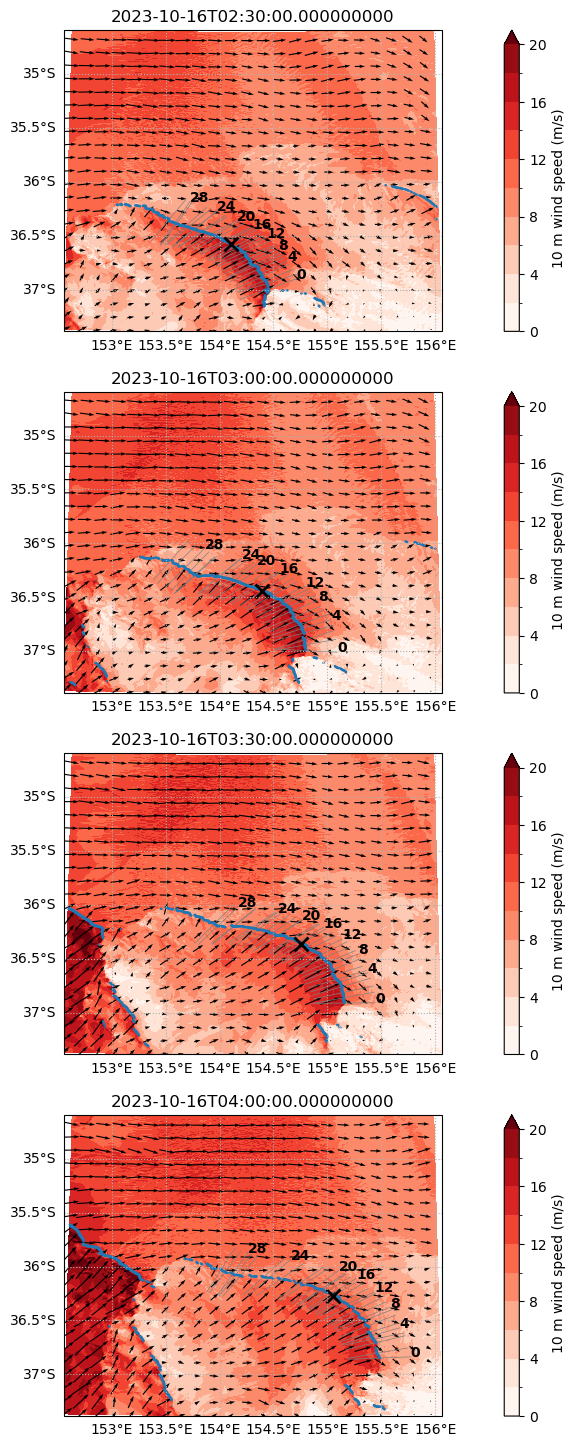

In [6]:
tpath = "/g/data/w40/ab4502/WRF_simulations/transects/"
hpath = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_nov23_shortlead/"
mean_motion_top = 6000
plot_radar=False

t_fname = ["tasman_d04_20231015_20231016_ramssa_nov23_shortlead_02:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_nov23_shortlead_03:00:00.nc",
           "tasman_d04_20231015_20231016_ramssa_nov23_shortlead_03:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_nov23_shortlead_04:00:00.nc"]
h_fname = ["highres_d04_2023-10-16_02:30:00",
           "highres_d04_2023-10-16_03:00:00",
           "highres_d04_2023-10-16_03:30:00",
           "highres_d04_2023-10-16_04:00:00"]
nov_list = []
nov_highres_list = []
nov_highres_wrf_list = []

plt.figure(figsize=[16,18])

cnt=1
for t, h in tqdm.tqdm(zip(t_fname,h_fname)):
    if plot_radar:
        ax=plt.subplot(len(t_fname),2,cnt,projection=ccrs.PlateCarree())
    else:
        ax=plt.subplot(len(t_fname),1,cnt,projection=ccrs.PlateCarree())        
    nov, nov_highres, nov_highres_wrf = load_transect(tpath,t,hpath,h,mean_motion_top)
    plot_transect_map(ax,nov, nov_highres, nov_highres_wrf)
    system_lat = nov.sel(transect=15,cross_line_idx=25,method="nearest").xy_lat.values
    system_lon = nov.sel(transect=15,cross_line_idx=25,method="nearest").xy_lon.values
    plt.gca().plot(system_lon,system_lat,marker="x",color="k",mew=2,ms=10)        
    cnt = cnt+1
    if plot_radar:
        ax=plt.subplot(len(t_fname),2,cnt,projection=ccrs.PlateCarree())
        plot_transect_radar(ax,nov, nov_highres, nov_highres_wrf)
        cnt=cnt+1
    nov_list.append(nov)
    nov_highres_list.append(nov_highres)
    nov_highres_wrf_list.append(nov_highres_wrf)    

4it [00:14,  3.53s/it]


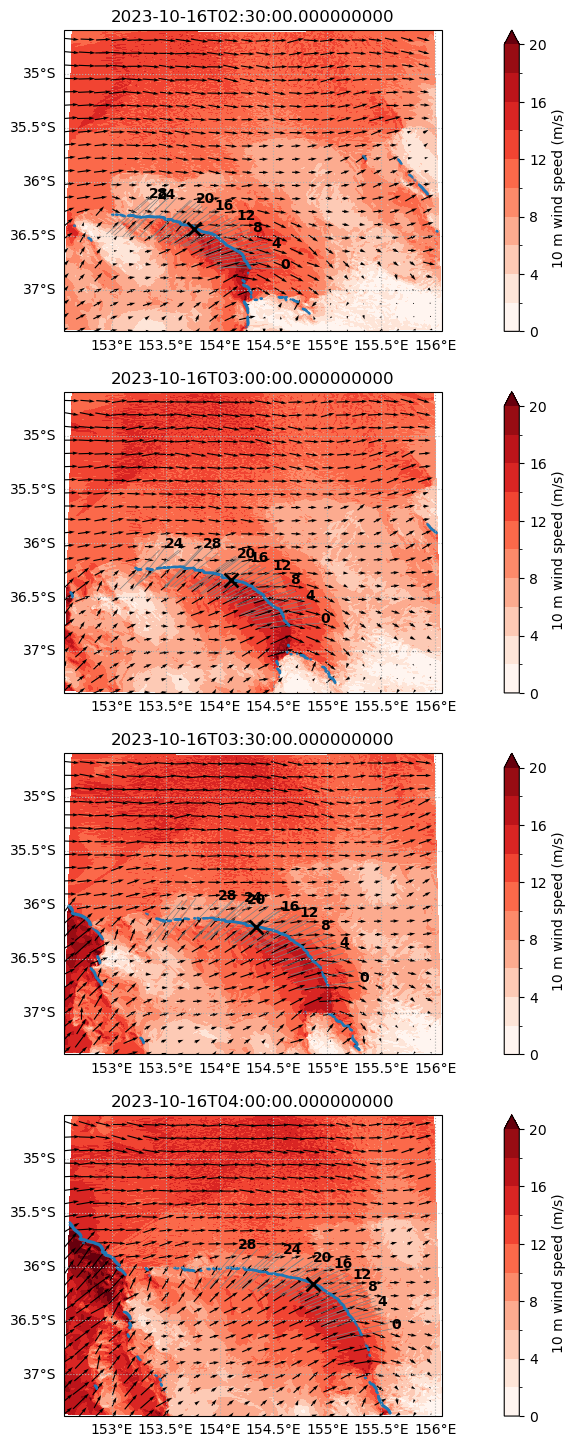

In [7]:
tpath = "/g/data/w40/ab4502/WRF_simulations/transects/"
hpath = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus/"
mean_motion_top = 6000
plot_radar=False

t_fname = ["tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus_02:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus_03:00:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus_03:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus_04:00:00.nc"]
h_fname = ["highres_d04_2023-10-16_02:30:00",
           "highres_d04_2023-10-16_03:00:00",
           "highres_d04_2023-10-16_03:30:00",
           "highres_d04_2023-10-16_04:00:00"]
plus3K_list = []
plus3K_highres_list = []
plus3K_highres_wrf_list = []

plt.figure(figsize=[16,18])

cnt=1
for t, h in tqdm.tqdm(zip(t_fname,h_fname)):
    if plot_radar:
        ax=plt.subplot(len(t_fname),2,cnt,projection=ccrs.PlateCarree())
    else:
        ax=plt.subplot(len(t_fname),1,cnt,projection=ccrs.PlateCarree())        
    plus3K, plus3K_highres, plus3K_highres_wrf = load_transect(tpath,t,hpath,h,mean_motion_top)
    plot_transect_map(ax,plus3K, plus3K_highres, plus3K_highres_wrf)
    system_lat = plus3K.sel(transect=15,cross_line_idx=25,method="nearest").xy_lat.values
    system_lon = plus3K.sel(transect=15,cross_line_idx=25,method="nearest").xy_lon.values
    plt.gca().plot(system_lon,system_lat,marker="x",color="k",mew=2,ms=10)        
    cnt = cnt+1
    if plot_radar:
        ax=plt.subplot(len(t_fname),2,cnt,projection=ccrs.PlateCarree())
        plot_transect_radar(ax,plus3K, plus3K_highres, plus3K_highres_wrf)
        cnt=cnt+1
    plus3K_list.append(plus3K)
    plus3K_highres_list.append(plus3K_highres)
    plus3K_highres_wrf_list.append(plus3K_highres_wrf)    

4it [00:13,  3.45s/it]


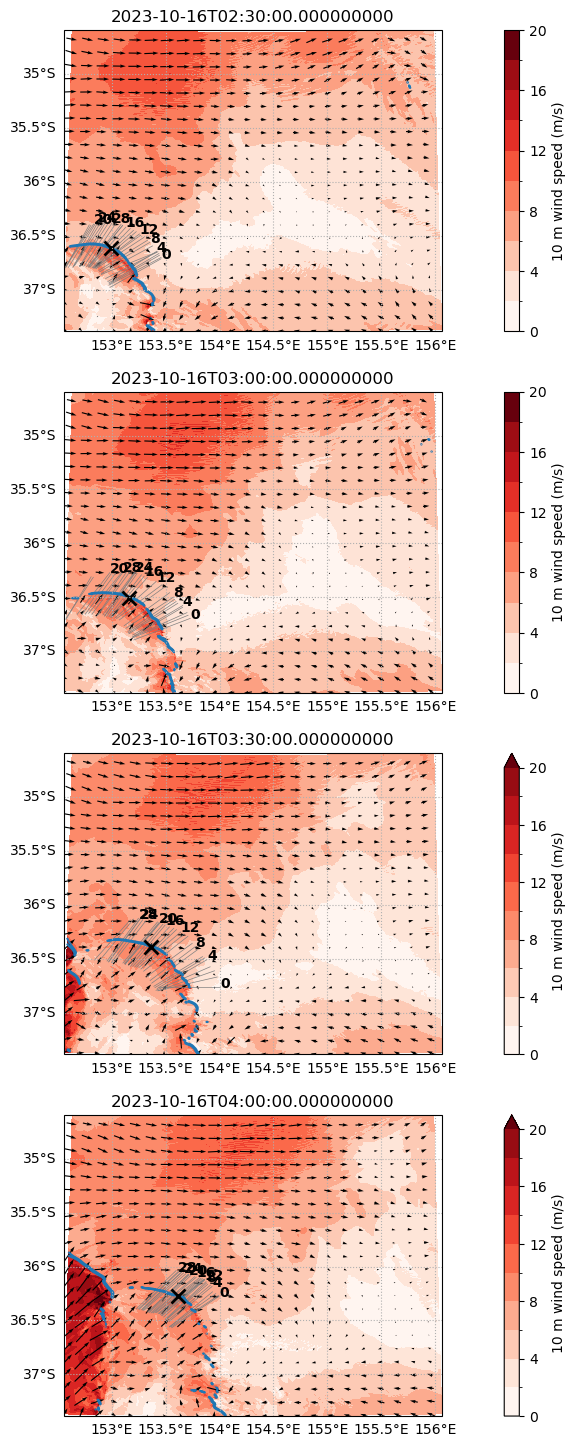

In [8]:
tpath = "/g/data/w40/ab4502/WRF_simulations/transects/"
hpath = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus/"
mean_motion_top = 6000
plot_radar=False

t_fname = ["tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus_02:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus_03:00:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus_03:30:00.nc",
           "tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus_04:00:00.nc"]
h_fname = ["highres_d04_2023-10-16_02:30:00",
           "highres_d04_2023-10-16_03:00:00",
           "highres_d04_2023-10-16_03:30:00",
           "highres_d04_2023-10-16_04:00:00"]
minus3K_list = []
minus3K_highres_list = []
minus3K_highres_wrf_list = []

plt.figure(figsize=[16,18])

cnt=1
for t, h in tqdm.tqdm(zip(t_fname,h_fname)):
    if plot_radar:
        ax=plt.subplot(len(t_fname),2,cnt,projection=ccrs.PlateCarree())
    else:
        ax=plt.subplot(len(t_fname),1,cnt,projection=ccrs.PlateCarree())        
    minus3K, minus3K_highres, minus3K_highres_wrf = load_transect(tpath,t,hpath,h,mean_motion_top)
    plot_transect_map(ax,minus3K, minus3K_highres, minus3K_highres_wrf,grad_theta_thresh=1)
    system_lat = minus3K.sel(transect=15,cross_line_idx=25,method="nearest").xy_lat.values
    system_lon = minus3K.sel(transect=15,cross_line_idx=25,method="nearest").xy_lon.values
    plt.gca().plot(system_lon,system_lat,marker="x",color="k",mew=2,ms=10)        
    cnt = cnt+1
    if plot_radar:
        ax=plt.subplot(len(t_fname),2,cnt,projection=ccrs.PlateCarree())
        plot_transect_radar(ax,minus3K, minus3K_highres, minus3K_highres_wrf)
        cnt=cnt+1
    minus3K_list.append(minus3K)
    minus3K_highres_list.append(minus3K_highres)
    minus3K_highres_wrf_list.append(minus3K_highres_wrf)    

In [9]:
def plot_reflectivity(ctrl):

    plt.figure()
    ctrl_w = ctrl[["system_relative_along_transect_wind","w"]].copy()
    #ctrl_w["w"] = ctrl_w["w"] * 2
    ctrl.reflectivity.sel(vertical=slice(0,8000)).mean("transect").plot(cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.linspace(0,40,11))
    ctrl_w.sel(vertical=slice(0,8000,3),cross_line_idx=slice(2,50,10)).mean("transect").plot.quiver("cross_line_idx","vertical","system_relative_along_transect_wind","w",width=0.005,color="k",scale=100)    
    

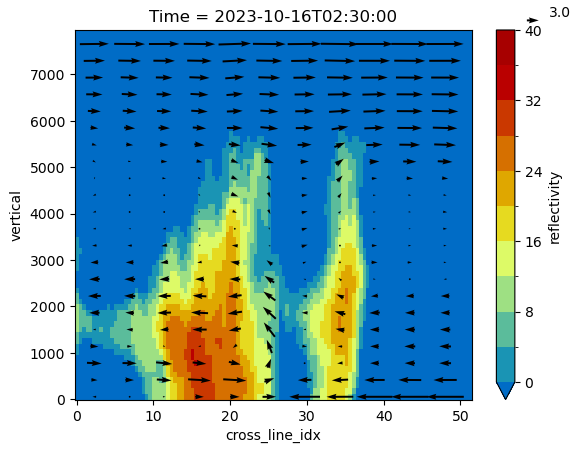

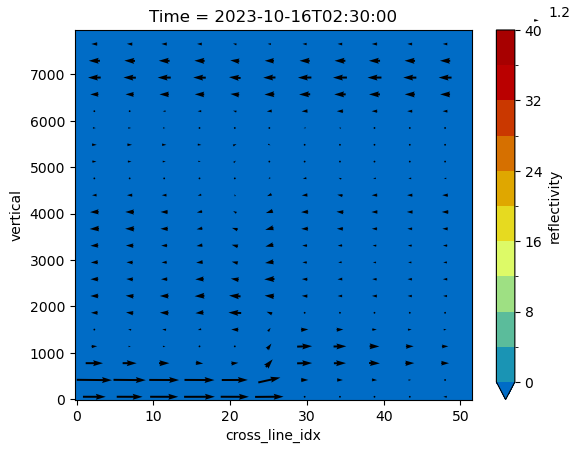

In [10]:
plot_reflectivity(ctrl_list[0].sel(transect=slice(0,9)))
plot_reflectivity(ctrl_list[0].sel(transect=slice(9,ctrl_list[1].transect.shape[0])))

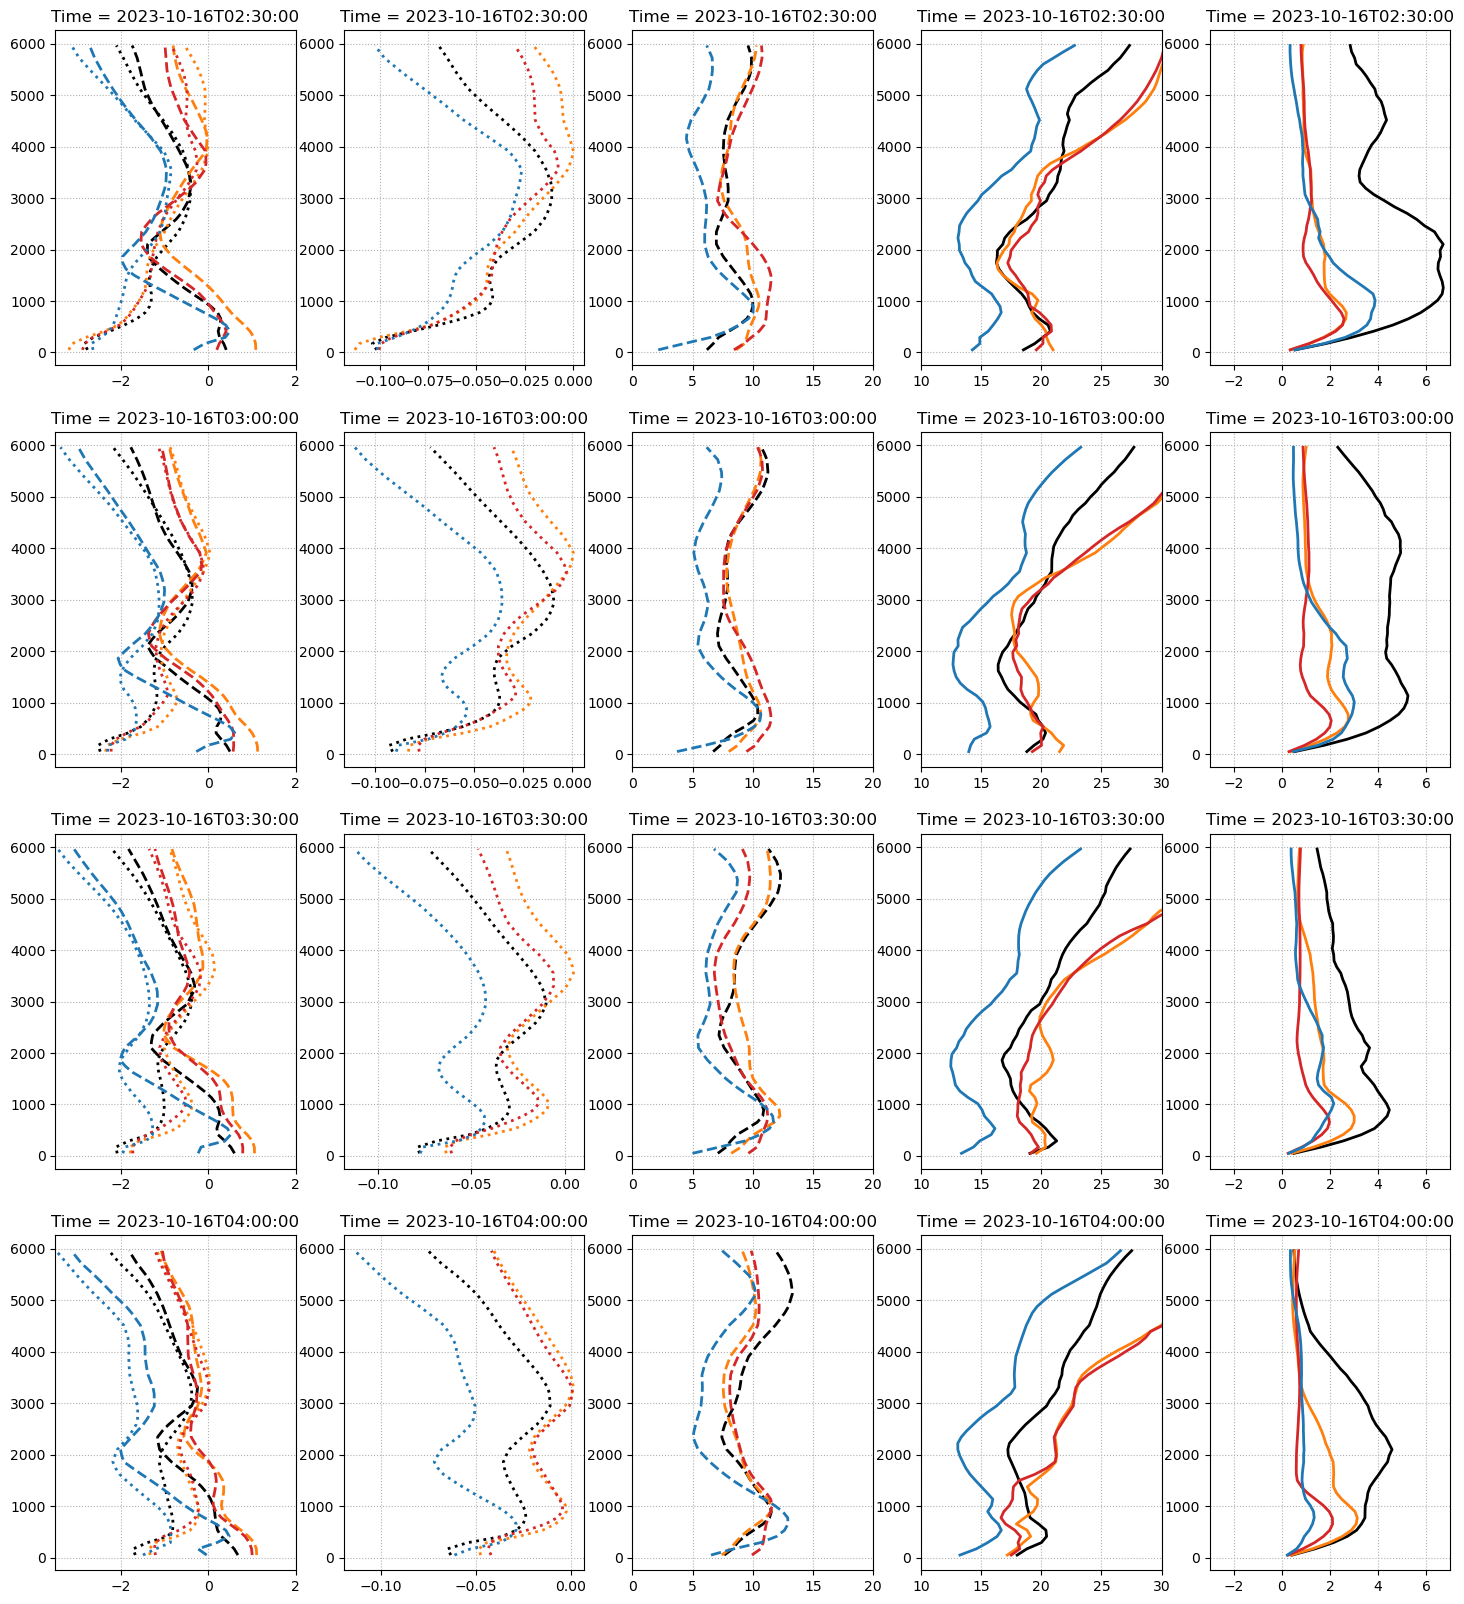

In [11]:
def plot_profile(ctrl,var,cross_slice,vert_slice,color,ls,func="mean",xlab="",ylab="",lw=2):
    if func=="mean":        
        ctrl.sel(vertical=vert_slice,cross_line_idx=cross_slice)[var].mean(("transect","cross_line_idx")).plot(y="vertical",color=color,ls=ls,lw=lw)
    elif func=="max_mean":
        ctrl.sel(vertical=vert_slice,cross_line_idx=cross_slice)[var].max("cross_line_idx").mean("transect").plot(y="vertical",color=color,ls=ls,lw=lw)        
    elif func=="min_mean":
        ctrl.sel(vertical=vert_slice,cross_line_idx=cross_slice)[var].min("cross_line_idx").mean("transect").plot(y="vertical",color=color,ls=ls,lw=lw)                
    plt.xlabel(xlab)
    plt.ylabel(ylab) 
    plt.gca().grid(ls=":")
    
plt.figure(figsize=[18,20])
rows=4
cols=5

for t in range(rows):
    plt.subplot(rows,cols,(t*cols)+1)
    plot_profile(ctrl_list[t],"theta_pert",slice(0,25),slice(0,6000),"k",ls=":",func="mean",xlab="",ylab="")
    plot_profile(ctrl_list[t],"theta_pert",slice(25,50),slice(0,6000),"k",ls="--",func="mean",xlab="",ylab="")
    
    plot_profile(nov_list[t],"theta_pert",slice(0,25),slice(0,6000),"tab:orange",ls=":",func="mean",xlab="",ylab="")
    plot_profile(nov_list[t],"theta_pert",slice(25,50),slice(0,6000),"tab:orange",ls="--",func="mean",xlab="",ylab="")
    
    plot_profile(plus3K_list[t],"theta_pert",slice(0,25),slice(0,6000),"tab:red",ls=":",func="mean",xlab="",ylab="")
    plot_profile(plus3K_list[t],"theta_pert",slice(25,50),slice(0,6000),"tab:red",ls="--",func="mean",xlab="",ylab="")    
    
    plot_profile(minus3K_list[t],"theta_pert",slice(0,25),slice(0,6000),"tab:blue",ls=":",func="mean",xlab="",ylab="")
    plot_profile(minus3K_list[t],"theta_pert",slice(25,50),slice(0,6000),"tab:blue",ls="--",func="mean",xlab="",ylab="")        
    
    plt.xlim([-3.5,2])
    
for t in range(rows):
    plt.subplot(rows,cols,(t*cols)+2)
    plot_profile(ctrl_list[t],"buoyancy",slice(0,25),slice(0,6000),"k",ls=":",func="mean",xlab="",ylab="")
    plot_profile(nov_list[t],"buoyancy",slice(0,25),slice(0,6000),"tab:orange",ls=":",func="mean",xlab="",ylab="")
    plot_profile(plus3K_list[t],"buoyancy",slice(0,25),slice(0,6000),"tab:red",ls=":",func="mean",xlab="",ylab="")
    plot_profile(minus3K_list[t],"buoyancy",slice(0,25),slice(0,6000),"tab:blue",ls=":",func="mean",xlab="",ylab="")    
#    plt.xlim([-3.5,1])    

for t in range(rows):
    plt.subplot(rows,cols,(t*cols)+3)
    plot_profile(ctrl_list[t],"along_transect_wind",slice(25,50),slice(0,6000),"k",ls="--",func="mean",xlab="",ylab="")
    plot_profile(nov_list[t],"along_transect_wind",slice(25,50),slice(0,6000),"tab:orange",ls="--",func="mean",xlab="",ylab="")
    plot_profile(plus3K_list[t],"along_transect_wind",slice(25,50),slice(0,6000),"tab:red",ls="--",func="mean",xlab="",ylab="")
    plot_profile(minus3K_list[t],"along_transect_wind",slice(25,50),slice(0,6000),"tab:blue",ls="--",func="mean",xlab="",ylab="")    
    plt.xlim([0,20])    
    
for t in range(rows):
    plt.subplot(rows,cols,(t*cols)+4)
    plot_profile(ctrl_list[t].sel(transect=slice(0,9)),"ground_rel_ws",slice(0,50),slice(0,6000),"k",ls="-",func="max_mean",xlab="",ylab="")
    plot_profile(nov_list[t].sel(transect=slice(0,9)),"ground_rel_ws",slice(0,50),slice(0,6000),"tab:orange",ls="-",func="max_mean",xlab="",ylab="")
    plot_profile(plus3K_list[t].sel(transect=slice(0,9)),"ground_rel_ws",slice(0,50),slice(0,6000),"tab:red",ls="-",func="max_mean",xlab="",ylab="")
    plot_profile(minus3K_list[t].sel(transect=slice(0,9)),"ground_rel_ws",slice(0,50),slice(0,6000),"tab:blue",ls="-",func="max_mean",xlab="",ylab="")    
    plt.xlim([10,30])        
    
for t in range(rows):
    plt.subplot(rows,cols,(t*cols)+5)
    plot_profile(ctrl_list[t].sel(transect=slice(0,9)),"w",slice(0,50),slice(0,6000),"k",ls="-",func="max_mean",xlab="",ylab="")
    plot_profile(nov_list[t].sel(transect=slice(0,9)),"w",slice(0,50),slice(0,6000),"tab:orange",ls="-",func="max_mean",xlab="",ylab="")
    plot_profile(plus3K_list[t].sel(transect=slice(0,9)),"w",slice(0,50),slice(0,6000),"tab:red",ls="-",func="max_mean",xlab="",ylab="")
    plot_profile(minus3K_list[t].sel(transect=slice(0,9)),"w",slice(0,50),slice(0,6000),"tab:blue",ls="-",func="max_mean",xlab="",ylab="")    

    plt.xlim([-3,7])            

In [21]:
def find_speed(ctrl_list):
    
    system_lats = []
    system_lons = []
    speed = []
    for i in range(len(ctrl_list)):
        for t in range(ctrl_list[i].transect.shape[0]):
            system_lat1 = ctrl_list[i-1].sel(transect=t,cross_line_idx=25,method="nearest").xy_lat.values
            system_lon1 = ctrl_list[i-1].sel(transect=t,cross_line_idx=25,method="nearest").xy_lon.values
            system_lat2 = ctrl_list[i].sel(transect=t,cross_line_idx=25,method="nearest").xy_lat.values
            system_lon2 = ctrl_list[i].sel(transect=t,cross_line_idx=25,method="nearest").xy_lon.values        
            speed.append((latlon_dist(system_lat1,system_lon1,system_lat2,system_lon2)/0.5/3.6))
        
    print(np.median(speed))
    
find_speed(ctrl_list)
find_speed(nov_list)
find_speed(plus3K_list)
find_speed(minus3K_list)

16.477211469003215
18.235024128985756
18.58965960258775
14.68406878923894
